In [164]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random, numpy as np
random.seed(42)
np.random.seed(42)

In [165]:
import pandas as pd


df = pd.read_excel('../data/demand_prediction_weekly1.xlsx')  # <-- change path if needed

In [166]:
medicine_name = input("Enter the medicine name from the list above: ")
#medicine_name = 'MEFORNIX-P TAB'
df_med = df[df['Product_Name'] == medicine_name].copy()

# Sort by week
#df_med = df_med.sort_values('Week')
df = df.sort_values('Week').reset_index(drop=True)


In [167]:
print(df_med.head())

        Product_Name      Week  Year  Week_Number  Total_Quantity
1016  MEFORNIX-P TAB  2021-W01  2021            1             275
1017  MEFORNIX-P TAB  2021-W02  2021            2             377
1018  MEFORNIX-P TAB  2021-W03  2021            3             402
1019  MEFORNIX-P TAB  2021-W04  2021            4             140
1020  MEFORNIX-P TAB  2021-W05  2021            5             189


In [168]:

# ---- Derive Approximate Month ----
# Since there are ~4.3 weeks per month, convert week number to month roughly
df_med['Month'] = np.ceil(df_med['Week_Number'] / 4.33).astype(int)
df_med['Month'] = df_med['Month'].clip(upper=12)


# ---- Derive Quarter ----
df_med['Quarter'] = ((df_med['Month'] - 1) // 3 + 1).astype(int)

# ---- Flags for Year Start/End ----
df_med['Is_Year_Start'] = (df_med['Week_Number'] <= 4).astype(int)
df_med['Is_Year_End'] = (df_med['Week_Number'] >= 48).astype(int)

df_med['Sin_Week'] = np.sin(2 * np.pi * df_med['Week_Number'] / 52)
df_med['Cos_Week'] = np.cos(2 * np.pi * df_med['Week_Number'] / 52)


In [169]:
print(df_med)

        Product_Name      Week  Year  Week_Number  Total_Quantity  Month  \
1016  MEFORNIX-P TAB  2021-W01  2021            1             275      1   
1017  MEFORNIX-P TAB  2021-W02  2021            2             377      1   
1018  MEFORNIX-P TAB  2021-W03  2021            3             402      1   
1019  MEFORNIX-P TAB  2021-W04  2021            4             140      1   
1020  MEFORNIX-P TAB  2021-W05  2021            5             189      2   
...              ...       ...   ...          ...             ...    ...   
1265  MEFORNIX-P TAB  2025-W38  2025           38             156      9   
1266  MEFORNIX-P TAB  2025-W39  2025           39             231     10   
1267  MEFORNIX-P TAB  2025-W40  2025           40             329     10   
1268  MEFORNIX-P TAB  2025-W41  2025           41             154     10   
1269  MEFORNIX-P TAB  2025-W42  2025           42             332     10   

      Quarter  Is_Year_Start  Is_Year_End  Sin_Week      Cos_Week  
1016        1      

In [170]:
for lag in range(1, 13):  # 12 weeks (3 months)
    df_med[f'lag_{lag}'] = df_med['Total_Quantity'].shift(lag)

df_med['rolling_mean_3'] = df_med['Total_Quantity'].shift(1).rolling(window=3).mean()
df_med['rolling_mean_5'] = df_med['Total_Quantity'].shift(1).rolling(window=5).mean()



df_med['rolling_mean_6'] = df_med['Total_Quantity'].shift(1).rolling(6).mean()
df_med['rolling_std_6'] = df_med['Total_Quantity'].shift(1).rolling(6).std()


df_med['rolling_mean_8'] = df_med['Total_Quantity'].shift(1).rolling(window=8).mean()
df_med['rolling_std_4'] = df_med['Total_Quantity'].shift(1).rolling(window=4).std()

df_med = df_med.dropna()


In [171]:
print(df_med.head())

        Product_Name      Week  Year  Week_Number  Total_Quantity  Month  \
1028  MEFORNIX-P TAB  2021-W13  2021           13             409      4   
1029  MEFORNIX-P TAB  2021-W14  2021           14             252      4   
1030  MEFORNIX-P TAB  2021-W15  2021           15             194      4   
1031  MEFORNIX-P TAB  2021-W16  2021           16             137      4   
1032  MEFORNIX-P TAB  2021-W17  2021           17             212      4   

      Quarter  Is_Year_Start  Is_Year_End  Sin_Week  ...  lag_9  lag_10  \
1028        2              0            0  1.000000  ...  140.0   402.0   
1029        2              0            0  0.992709  ...  189.0   140.0   
1030        2              0            0  0.970942  ...  320.0   189.0   
1031        2              0            0  0.935016  ...  140.0   320.0   
1032        2              0            0  0.885456  ...  128.0   140.0   

      lag_11  lag_12  rolling_mean_3  rolling_mean_5  rolling_mean_6  \
1028   377.0   275.0

In [172]:
from pickle import TRUE

from sympy import false


X_med = df_med.drop(columns=['Total_Quantity', 'Week', 'Product_Name'])
y_med = df_med['Total_Quantity']

# Drop non-numeric columns if any
#X_med = X_med.apply(pd.to_numeric, errors='ignore')
#non_numeric_cols = X_med.select_dtypes(include=['object']).columns
#if len(non_numeric_cols) > 0:
#    X_med = X_med.drop(columns=non_numeric_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X_med, y_med, test_size=0.2, shuffle=False
)

#X_train, X_valid, y_train, y_valid = train_test_split(
#    X_train, y_train, test_size=0.1, shuffle=False)

In [173]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
a = X_train
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [174]:
print(X_train)
print(y_train)

[[-1.43496681 -0.99496773 -0.85638985 ...  2.76292388 -0.37816611
   1.97214065]
 [-1.43496681 -0.92606613 -0.85638985 ...  2.20536306  0.01538617
   1.76811341]
 [-1.43496681 -0.85716453 -0.85638985 ...  1.61004265 -0.10625726
   1.79763203]
 ...
 [ 1.36249374  1.14098202  1.25104674 ... -0.37559902  0.80070185
   0.28581621]
 [ 1.36249374  1.20988362  1.25104674 ... -0.37945726  0.91518978
   0.28023644]
 [ 1.36249374  1.27878523  1.25104674 ... -0.13608756  1.13164354
  -1.02108471]]
1028    409
1029    252
1030    194
1031    137
1032    212
       ... 
1216    514
1217    503
1218    431
1219    542
1220    388
Name: Total_Quantity, Length: 193, dtype: int64


In [175]:
from xgboost import XGBRegressor

"""

| Parameter        | Meaning           | Effect                  | Typical Range |
| ---------------- | ----------------- | ----------------------- | ------------- |
| n_estimators     | number of trees   | More trees = better fit | 300–1000      |
| learning_rate    | Step size         | Lower = more stable     | 0.01–0.1      |
| max_depth        | Tree depth        | Higher = more complex   | 3–10          |
| subsample        | Row sampling      | Prevents overfitting    | 0.5–1.0       |
| colsample_bytree | Column sampling   | Prevents overfitting    | 0.6–1.0       |
| min_child_weight | Min data per leaf | Higher = simpler        | 1–10          |
| gamma            | Split threshold   | Higher = conservative   | 0–1           |
| reg_lambda       | L2 regularization | Higher = less overfit   | 0.1–10        |

"""


model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
)



model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ✅ Compute metrics directly without shifting
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

final_xgb = model




MAE: 118.65
RMSE: 142.19
R²: -0.52


In [176]:
"""

model = XGBRegressor(
    objective="reg:absoluteerror",     # still best for handling spikes
    n_estimators=600,                  # slightly fewer trees → faster & smoother
    learning_rate=0.05,                # reacts faster to changes
    max_depth=6,                       # slightly deeper for better short-term sensitivity
    subsample=0.8,                     # more training data per tree → stronger trends
    colsample_bytree=0.8,              # keeps moderate feature randomness
    min_child_weight=2,                # a bit lower to allow finer local splits
    gamma=0.15,                        # mild penalty for complexity
    reg_lambda=1.5,                    # moderate L2 regularization
    reg_alpha=0.3,                     # slightly less L1 regularization (more flexibility)
    random_state=42
)
for MEFORNIX P


model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
)
MAE (aligned): 11.70
RMSE (aligned): 15.51
R² (aligned): 0.54




model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.0,
)


model = XGBRegressor(
    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    reg_lambda=1.5,
)


{'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=1.0,
    random_state=42
)

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    random_state=42,
    reg_lambda=2.0,
    reg_alpha=0.5
)

"""

'\n\nmodel = XGBRegressor(\n    objective="reg:absoluteerror",     # still best for handling spikes\n    n_estimators=600,                  # slightly fewer trees → faster & smoother\n    learning_rate=0.05,                # reacts faster to changes\n    max_depth=6,                       # slightly deeper for better short-term sensitivity\n    subsample=0.8,                     # more training data per tree → stronger trends\n    colsample_bytree=0.8,              # keeps moderate feature randomness\n    min_child_weight=2,                # a bit lower to allow finer local splits\n    gamma=0.15,                        # mild penalty for complexity\n    reg_lambda=1.5,                    # moderate L2 regularization\n    reg_alpha=0.3,                     # slightly less L1 regularization (more flexibility)\n    random_state=42\n)\nfor MEFORNIX P\n\n\nmodel = XGBRegressor(\n    objective= "reg:squarederror",  # reg:squarederror,  reg:absoluteerror  use if there are sudden hikes\n    n

PLOTTING

C:\Users\Strix\AppData\Local\Temp\ipykernel_12552\3012695651.py:18: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Strix\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


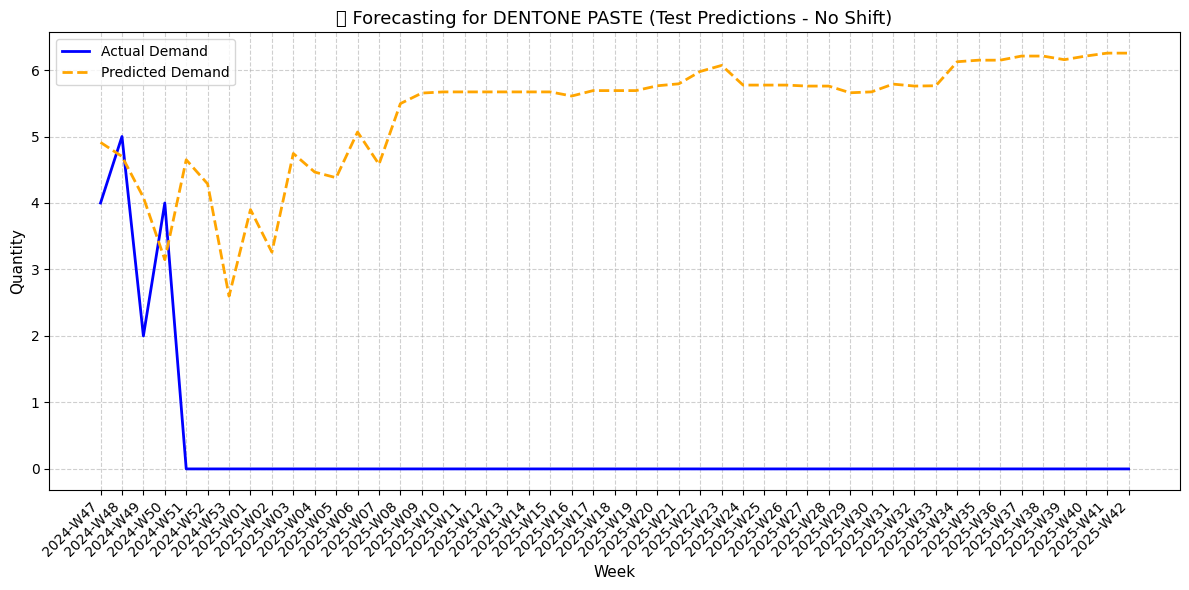

C:\Users\Strix\AppData\Local\Temp\ipykernel_12552\3012695651.py:48: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Strix\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


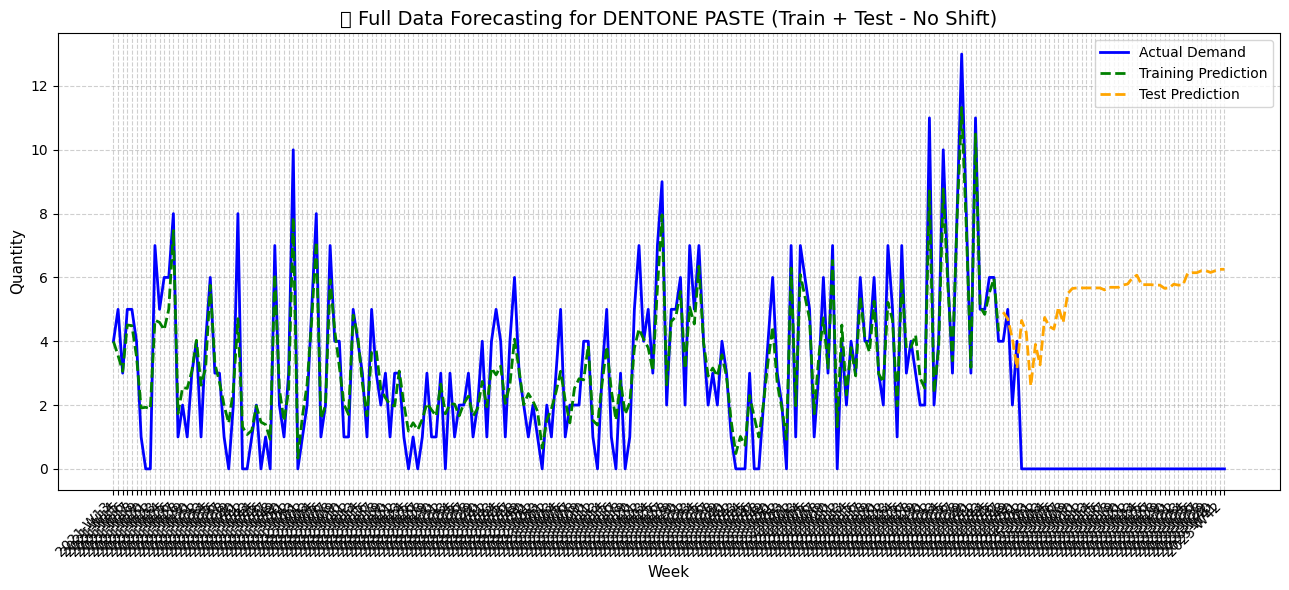

In [163]:
import matplotlib.pyplot as plt

# 🟦 TEST SET (No Shift)

# Week labels for test set
test_weeks = df_med.loc[y_test.index, 'Week'].astype(str).values

plt.figure(figsize=(12, 6))
plt.plot(test_weeks, y_test.values, color='blue', label='Actual Demand', linewidth=2)
plt.plot(test_weeks, y_pred, color='orange', linestyle='--', label='Predicted Demand', linewidth=2)

plt.title(f'🔸 Forecasting for {medicine_name} (Test Predictions - No Shift)', fontsize=13)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Quantity', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 🟩 FULL DATA (Train + Test - No Shift)

# Training predictions
train_weeks = df_med.loc[y_train.index, 'Week'].astype(str).values
train_preds = model.predict(X_train)

# Test predictions (already aligned)
test_weeks = df_med.loc[y_test.index, 'Week'].astype(str).values
test_preds = y_pred

plt.figure(figsize=(13, 6))
plt.plot(df_med['Week'].astype(str).values, df_med['Total_Quantity'].values,
         color='blue', label='Actual Demand', linewidth=2)

plt.plot(train_weeks, train_preds,
         color='green', linestyle='--', label='Training Prediction', linewidth=2)

plt.plot(test_weeks, test_preds,
         color='orange', linestyle='--', label='Test Prediction', linewidth=2)

plt.title(f'📈 Full Data Forecasting for {medicine_name} (Train + Test - No Shift)', fontsize=14)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Quantity', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


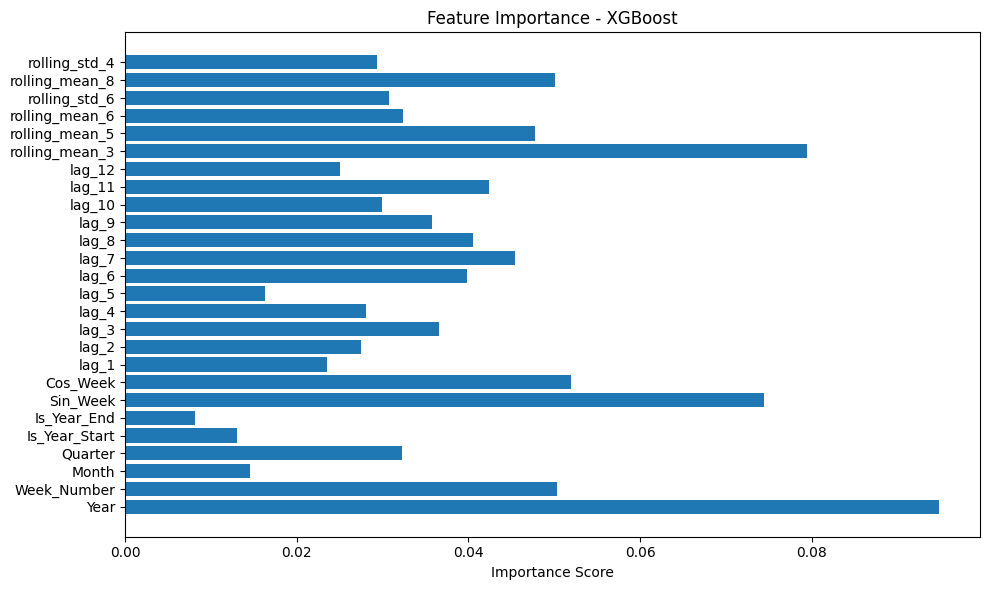

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(a.columns, model.feature_importances_)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

MODEL SAVING

In [ ]:

#model.save_model(f"../saved models/xgboost_{medicine_name}.json")


RANDOMIZED SEARCH

Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best Parameters Found:
{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.7}
🏆 Best CV MAE: 99.23

📊 Final Model Performance (NO Shift):
MAE:  117.25
RMSE: 139.14
R²:   -0.45


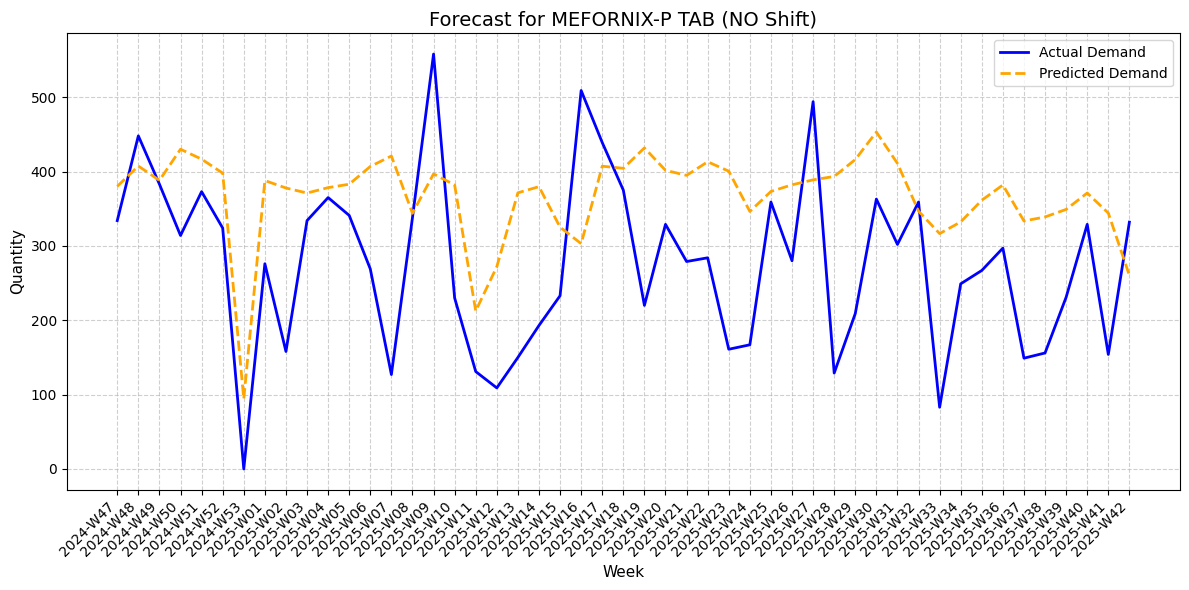

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 🔍 RandomizedSearchCV Setup
# ============================
param_grid = {
    'n_estimators': [200, 300, 400, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 8, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)

print("\n✅ Best Parameters Found:")
print(search.best_params_)
print(f"🏆 Best CV MAE: {abs(search.best_score_):.2f}")

# ============================
# 🚀 Retrain With Best Params
# ============================
best_params = search.best_params_

final_xgb = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)

final_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# ============================
# 📈 Predict (NO SHIFT)
# ============================
y_pred = final_xgb.predict(X_test)

# ============================
# 📊 Metrics Without Shift
# ============================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Final Model Performance (NO Shift):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

# ============================
# 📉 Plot - No Shift
# ============================
test_weeks = df_med.loc[y_test.index, 'Week'].astype(str).values

plt.figure(figsize=(12, 6))
plt.plot(test_weeks, y_test.values, color='blue', label='Actual Demand', linewidth=2)
plt.plot(test_weeks, y_pred, color='orange', linestyle='--', label='Predicted Demand', linewidth=2)

plt.title(f'Forecast for {medicine_name} (NO Shift)', fontsize=14)
plt.xlabel('Week', fontsize=11)
plt.ylabel('Quantity', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


MODEL PREDICTION FOR NEXT TWO MONTHS

       Week  Predicted_Quantity
0  2025-W43              353.22
1  2025-W44              376.02
2  2025-W45              353.37
3  2025-W46              379.67
4  2025-W47              431.14
5  2025-W48              470.47
6  2025-W49              462.27
7  2025-W50              487.47
8  2025-W51              463.35


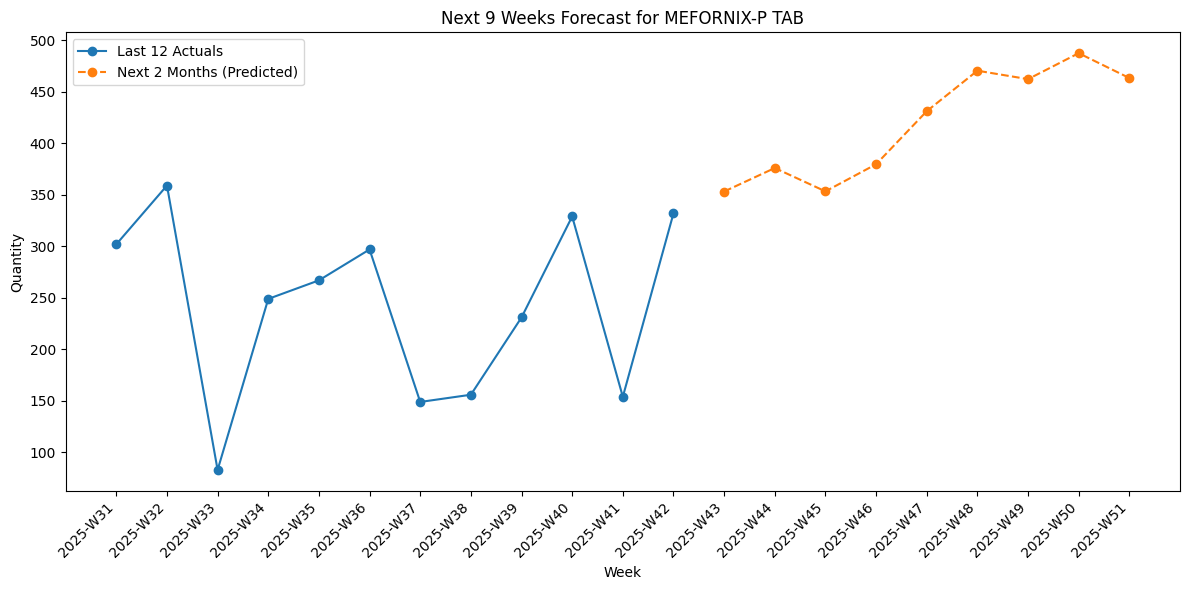

In [29]:
# Next 2 months prediction (~9 weeks) using iterative lag-features
n_weeks = 9  # ~2 months (4.33 weeks/month -> ~8.66 -> 9)
last_row = df_med.iloc[-1]
start_year = int(last_row['Year'])
start_week = int(last_row['Week_Number'])

# initialize prev values (most recent first) from last 12 real observations
prev_qty = list(df_med['Total_Quantity'].astype(float).values[-12:][::-1])  # lag_1 = prev_qty[0]

preds = []
pred_weeks = []

for i in range(n_weeks):
    # compute year/week (simple rollover at 53)
    wk = start_week + i + 1
    yr = start_year
    while wk > 53:
        wk -= 53
        yr += 1

    month = int(np.ceil(wk / 4.33))
    month = min(month, 12)
    quarter = ((month - 1) // 3) + 1
    is_year_start = int(wk <= 4)
    is_year_end = int(wk >= 48)
    sin_week = np.sin(2 * np.pi * wk / 52)
    cos_week = np.cos(2 * np.pi * wk / 52)

    # prepare lag features (ensure we have 12 entries in prev_qty)
    lags = {f'lag_{j}': (prev_qty[j-1] if j-1 < len(prev_qty) else 0.0) for j in range(1, 13)}

    # rolling features based on previous values (exclude current)
    def safe_mean(arr, k):
        vals = arr[:k] if len(arr) >= 1 else [0.0]
        return float(np.mean(vals[:k])) if len(vals) >= 1 else 0.0

    def safe_std(arr, k):
        vals = arr[:k]
        if len(vals) <= 1:
            return 0.0
        return float(np.std(vals[:k], ddof=1))

    rm3 = safe_mean(prev_qty, 3)
    rm5 = safe_mean(prev_qty, 5)
    rm6 = safe_mean(prev_qty, 6)
    rs6 = safe_std(prev_qty, 6)
    rm8 = safe_mean(prev_qty, 8)
    rs4 = safe_std(prev_qty, 4)

    # build feature row matching 'a' columns order
    row = {
        'Year': yr,
        'Week_Number': wk,
        'Month': month,
        'Quarter': quarter,
        'Is_Year_Start': is_year_start,
        'Is_Year_End': is_year_end,
        'Sin_Week': sin_week,
        'Cos_Week': cos_week,
        **lags,
        'rolling_mean_3': rm3,
        'rolling_mean_5': rm5,
        'rolling_mean_6': rm6,
        'rolling_std_6': rs6,
        'rolling_mean_8': rm8,
        'rolling_std_4': rs4
    }

    feat_df = pd.DataFrame([row])
    # ensure same column order as training features
    feat_df = feat_df[a.columns]

    # scale and predict
    X_future = scaler.transform(feat_df)
    pred = final_xgb.predict(X_future)[0]
    preds.append(float(pred))
    pred_weeks.append(f"{yr}-W{wk:02d}")

    # update prev_qty (most recent first)
    prev_qty.insert(0, float(pred))
    prev_qty = prev_qty[:12]  # keep last 12

# show results
future_df = pd.DataFrame({'Week': pred_weeks, 'Predicted_Quantity': np.round(preds, 2)})
print(future_df)



# optional quick plot
last_12_weeks = df_med['Week'].astype(str).values[-12:]
last_12_actuals = df_med['Total_Quantity'].values[-12:]

plt.figure(figsize=(12,6))
plt.plot(last_12_weeks, last_12_actuals, marker='o', label='Last 12 Actuals')
plt.plot(pred_weeks, preds, marker='o', linestyle='--', label='Next 2 Months (Predicted)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.title(f'Next {n_weeks} Weeks Forecast for {medicine_name}')
plt.legend()
plt.tight_layout()
plt.show()